In [8]:
# visually inspect carbon traces
import sys
import numpy as np
import matplotlib.pyplot as plt
import carbonTraces
import metric

In [9]:
# colorDict: for each name, save a corresponding hex color
colorDict = {
    "us-east-1": "#1f77b4",
    "us-west-1": "#2ca02c",
    "us-west-2": "#d62728",
    "eu-west-2": "#9467bd",
    "eu-west-3": "#8c564b",
    "eu-central-1": "#e377c2",
    "ap-northeast-2": "#bcbd22",
    "ap-southeast-2": "#1f77b4",
    "ap-south-2": "#ff7f0e",
    "sa-east-1": "#2ca02c",
    "ca-central-1": "#d62728",
    "eu-north-1": "#9467bd",
    "ap-east-1": "#8c564b",
    "il-central-1": "#e377c2",
    "af-south-1": "#7f7f7f",
    "cn-north-1": "#bcbd22",
}

# AWS regions
# get the parameters from the command line

# how many regions to choose
# regions = int(sys.argv[1])

# gigabytes of data that need to be "transferred" (i.e. the diameter of the metric space)
setGB = 1 # float(sys.argv[1])

# scale factor for metric space
eastToWest = 221.0427046263345 # milliseconds
dist = eastToWest
minutesPerGB = 1.72118 
carbonPerGB = (minutesPerGB / 60) * 700
scale = setGB * (carbonPerGB / eastToWest)

# job length (in hours)
job_length = 2

# get tau from cmd args
tau = (1/scale) * (1/job_length) #float(sys.argv[2]) / scale

# load in metric space
m = metric.MetricSpace(tau)
names = m.get_names()

# get the diameter
D = m.diameter() * scale

# get the distance matrix
simplex_names, c_simplex, simplex_distances = m.generate_simplex_distances()
dim = len(simplex_names)

# get the weight vector, the c vector, the name vector, and phi inverse
weights = m.get_weight_vector()
c_vector, name_vector = m.get_unit_c_vector()
phi_inverse = m.phi_inverse(names, name_vector, simplex_names)
phi = m.phi(names, name_vector, simplex_names)

# get the carbon trace
datetimes, carbon_vector = carbonTraces.get_numpy(m)

# get the simplex carbon trace
carbon_simplex = carbonTraces.get_simplex(simplex_names)

In [10]:
# get a random week (7 days * 24 hours)
T = 7 * 24
# randomly choose an index from datetimes, and make sure there are at least T days including/after that index
index = np.random.randint(0, len(datetimes) - T)
dtSequence = datetimes[index:index+T]
print(index)

# get the carbon traces for the sequence
simplexSequence = carbon_simplex[index:index+T, :]

20939


In [11]:
print(dtSequence.index[0])

20939


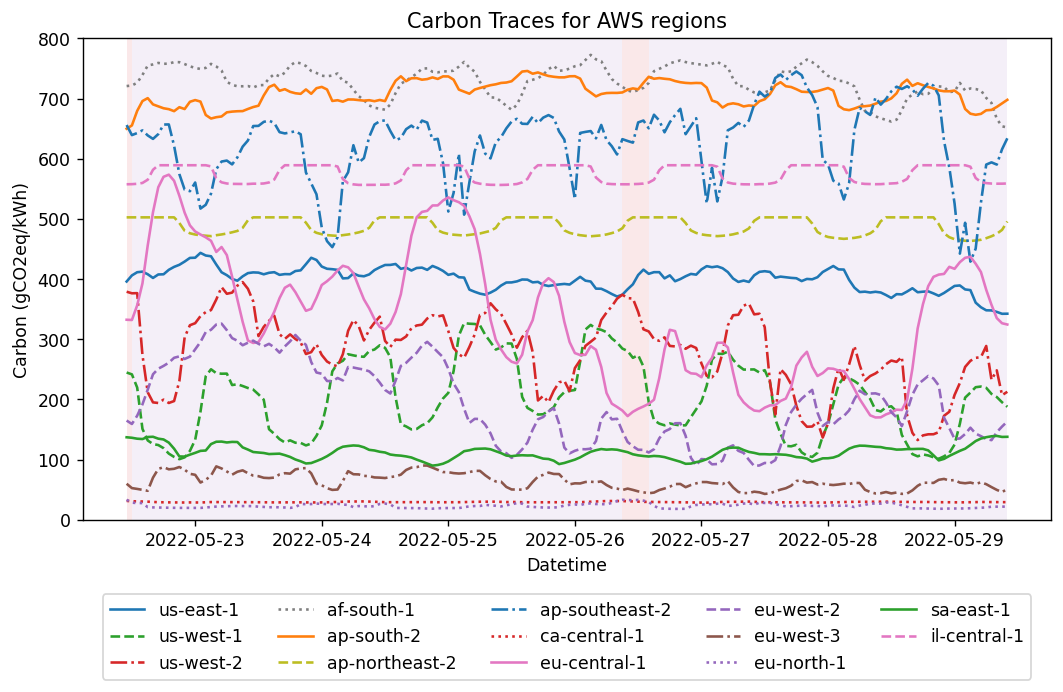

In [12]:
import itertools
# plot once for each region
names = m.get_names()
plt.figure(figsize=(10, 5), dpi=125)
linestyles = ['-', '--', '-.', ':']
# create iterator for linestyles, make the iterator infinite
linestyle = itertools.cycle(linestyles)

for i, name in enumerate(names):
    regionIndex = simplex_names.index(name + " ON")
    carbonTrace = simplexSequence[:, regionIndex]
    index = i
    if index > 9:
        index = index - 9
    plt.plot(dtSequence, carbonTrace, label=name, linestyle=next(linestyle), color=colorDict[name])
# for each hour of the plotted week, shade the background with the color of the region with the lowest carbon
for i in range(T-1):
    # get the carbon for each region at this hour
    carbon = simplexSequence[i, :]
    # get the region with the lowest nonzero carbon
    minIndex = np.argmin(carbon[np.nonzero(carbon)])*2
    minRegion = simplex_names[minIndex]
    colorIndex = names.index(minRegion[:-3])
    # shade the background
    plt.axvspan(dtSequence[dtSequence.index[i]], dtSequence[dtSequence.index[i+1]], facecolor=colorDict[minRegion[:-3]], alpha=0.1)
plt.xlabel('Datetime')
plt.ylim(0, 800)
plt.ylabel('Carbon (gCO2eq/kWh)')
plt.title('Carbon Traces for AWS regions')
# put the legend outside the figure at the bottom
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=5)
plt.show()

# # print the carbon trace for eu-west-3
# regionIndex = simplex_names.index("eu-west-3 ON")
# carbonTrace = simplexSequence[:, regionIndex]
# print(carbonTrace)

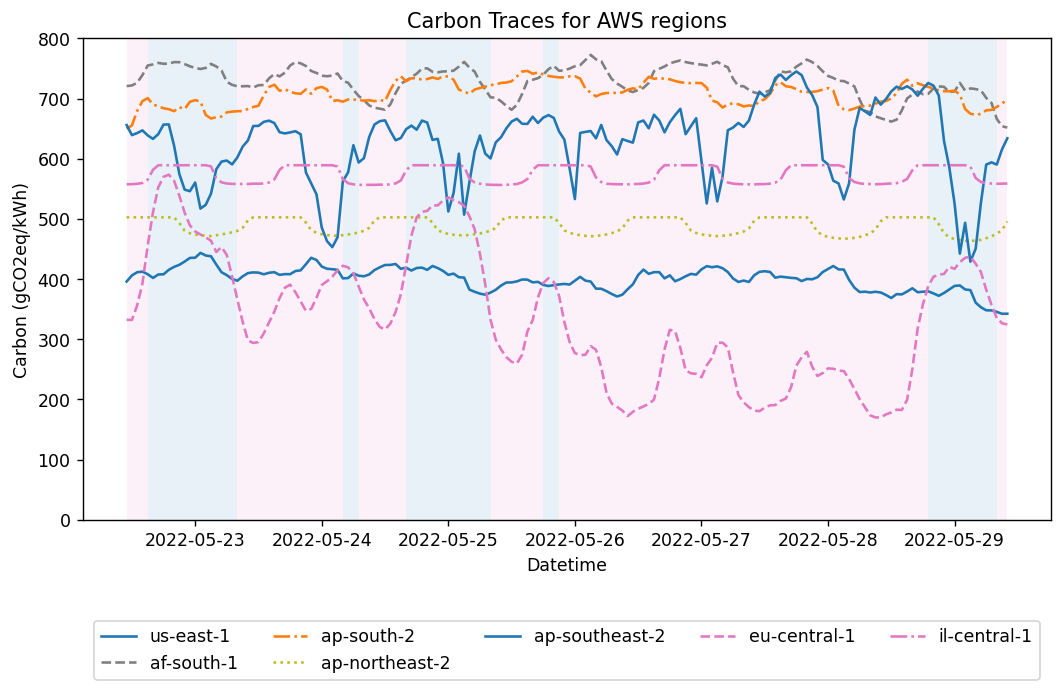

In [13]:
# pick a smaller subset of regions
# AWS regions
newNames = [
    "us-east-1",      # US East (N. Virginia)
    # "us-west-2",      # US West (Oregon)
    "af-south-1",     # Africa (Cape Town)
    "ap-south-2",     # Asia Pacific (Hyderabad)
    "ap-northeast-2", # Asia Pacific (Seoul)
    "ap-southeast-2", # Asia Pacific (Sydney)
    "eu-central-1",   # Europe (Frankfurt)
    # "eu-west-2",      # Europe (London)
    "il-central-1"    # Israel (Tel Aviv)
]

simplex_newNames = []
# create a new simplex_names vector
for name in newNames:
    simplex_newNames.append(name + " ON")
    simplex_newNames.append(name + " OFF")

# get the simplex carbon trace
carbon_simplex = carbonTraces.get_simplex(simplex_newNames)

# and the same week
simplexSequence = carbon_simplex[dtSequence.index[0]:dtSequence.index[0]+T, :]

# plot once for each region
plt.figure(figsize=(10, 5), dpi=125)
linestyles = ['-', '--', '-.', ':']
# create iterator for linestyles, make the iterator infinite
linestyle = itertools.cycle(linestyles)

# create color cycle, one for each region
colors = plt.get_cmap('tab10')
color_cycle = itertools.cycle(colors(range(10)))
color_index_list = list(colors(range(10)))

for i, name in enumerate(newNames):
    regionIndex = simplex_newNames.index(name + " ON")
    carbonTrace = simplexSequence[:, regionIndex]
    plt.plot(dtSequence, carbonTrace, label=name, linestyle=next(linestyle), color=colorDict[name])
# for each hour of the plotted week, shade the background with the color of the region with the lowest carbon
for i in range(T-1):
    # get the carbon for each region at this hour
    carbon = simplexSequence[i, :]
    # get the region with the lowest nonzero carbon
    minIndex = np.argmin(carbon[np.nonzero(carbon)])*2
    minRegion = simplex_newNames[minIndex]
    colorIndex = newNames.index(minRegion[:-3])
    # shade the background
    plt.axvspan(dtSequence[dtSequence.index[i]], dtSequence[dtSequence.index[i+1]], facecolor=colorDict[minRegion[:-3]], alpha=0.1)
plt.xlabel('Datetime')
plt.ylabel('Carbon (gCO2eq/kWh)')
plt.ylim(0, 800)
plt.title('Carbon Traces for AWS regions')
# put the legend outside the figure at the bottom
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=5)
plt.show()

# # print the carbon trace for eu-west-3
# regionIndex = simplex_newNames.index("eu-west-3 ON")
# carbonTrace = simplexSequence[:, regionIndex]
# print(carbonTrace)